In [14]:
# Import project dependencies

import pandas as pd
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import  word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,recall_score,precision_score
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from matplotlib import pyplot
from keras import backend as K
from keras.layers import MaxPool1D
from keras.models import Model

# glove vectorizer dependencies
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import io
import os

In [15]:
# Read csv dataset and save to df

filePath = 'TOTAL_TEXTS_SETOPATI.csv'
VALIDATION_SPLIT = 0.3
MAX_SEQUENCE_LENGTH = 1000
Embedding = 20000
EMBEDDING_DIM = 300

df = pd.read_csv(filePath)
print("DataFrame Size: "+ str(df.size))

DataFrame Size: 520235


In [16]:
#Preprocessing {Remove Stop words using nltk}

stop_words = stopwords.words("nepali")
def string_manipulation(df,column)  : 
    df[column] = df[column].apply(lambda x: re.sub('[।(),०-९<<?!,—,–,/,’,‘,:,\u200d]', '', x))
    df[column] = df[column].apply(lambda x: " ".join([i for i in x.split()if i not in (stop_words)]))
    return df
Data = string_manipulation(df,"text")

In [17]:
# convert word into vector

print('Indexing word vectors.')
embeddings_dict = {}

# Used NPVec1: Word Embeddings for Nepali for glove from [https://github.com/nowalab/nepali-word-embeddings]
# processed.glove.txt, processed_normalized_stemmed.glove 

with open("processed.glove", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

print('Found %s word vectors.' % len(embeddings_dict))

Indexing word vectors.
Found 663564 word vectors.


In [18]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
# second, prepare text samples and their labels
print('Processing text dataset')

newsTexts = Data['text'].tolist()
labels_index = {}  # dictionary mapping label name to numeric id
labels = [] # list of label ids
allCategoryDataList = Data['catagory']

indexCount = 0
for category in allCategoryDataList.unique():
    labels_index[category] = indexCount
    indexCount = indexCount + 1

for category in allCategoryDataList.tolist():
    labels.append(labels_index[category])
        
print('Found %s news texts.' % len(newsTexts))
print('Found %s news labels.' % len(labels))


Processing text dataset
Found 104047 news texts.
Found 104047 news labels.


In [20]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(newsTexts)
sequences = tokenizer.texts_to_sequences(newsTexts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labelsCategorical = to_categorical(np.asarray(labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labelsCategorical.shape)
print('label tensor:', labelsCategorical[0])

# split the data into a training set(70%) and a validation set(30%)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
finalLabels = labelsCategorical[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = finalLabels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = finalLabels[-num_validation_samples:]

Found 899236 unique tokens.
Shape of data tensor: (104047, 1000)
Shape of label tensor: (104047, 63)
label tensor: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print("done")

Preparing embedding matrix.
done


In [22]:
# print('Training model. CNN CNN Model.')

# # train a 1D convnet with global maxpooling
# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)

# x = Conv1D(128, 5, activation='relu')(embedded_sequences)
# x1 = Dropout(0.2)(x)
# x2 = MaxPooling1D(5)(x1)
# x3 = Conv1D(128, 5, activation='relu')(x2)
# x4 = Dropout(0.3)(x3)
# x5 = MaxPooling1D(5)(x4)
# x6 = Conv1D(128, 5, activation='relu')(x5)
# x7 = GlobalMaxPooling1D()(x6)
# x8 = Dense(128, activation='relu')(x7)
# print("len labels:", str(len(labels_index)))
# preds = Dense(len(labels_index), activation='softmax')(x8)

# print("Preds shape: ", preds.shape)
# print("sequence_input shape: ", sequence_input.shape)

# model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc', f1_m, precision_m, recall_m])

# print("Shape of x_train: ", x_train.shape)
# print("Shape of y_train: ", y_train.shape)
# print("Shape of x_val: ", x_val.shape)
# print("Shape of y_val: ", y_val.shape)
# print(model.output_shape)
# model.summary()


# history = model.fit(x_train, y_train,
#           batch_size=128,
#           epochs=15,
#           validation_data=(x_val, y_val))

In [23]:
# # print('Training model. CNN biLstm Model.')
# from keras.models import Sequential
# from keras.layers import Embedding
# from tensorflow.keras.layers import Bidirectional
# from keras.layers import LSTM
# from keras.layers import Activation


# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)

# model = Sequential()
# model.add(embedding_layer)
# # model.add(Embedding(embedded_sequences, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length = maxlen, trainable=False))
# model.add(Dropout(0.2)) # embedding dropouts
# model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, activation = 'tanh'))) # weight drop on recurrent layers using recurrent_dropout
# model.add(GlobalMaxPooling1D())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(63))
# model.add(Activation('sigmoid'))

# model.summary()
# model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam', metrics = ['accuracy'])
    

# # train the model
# # model.fit(x_train, y_train, X_val=x_val, y_val=y_val,
# #     epoch_num=15, optimizer='adam', verbose=True)
# history = model.fit(x_train, y_train,
#           batch_size=128,
#           epochs=15,
#           validation_data=(x_val, y_val))

In [37]:
# CNN Bilstm attention
from keras.layers import Input, Dense, LSTM, concatenate,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model


from tensorflow.keras.layers import Attention
from keras.layers.core import *
from keras.models import *

lstm_units = 64
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = concatenate([inputs, a_probs])
    return output_attention_mul

def attention_model():
#     inputs = Input(shape= x_train.shape)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    
    x = Conv1D(filters = 128, kernel_size = 5, activation = 'relu')(embedded_sequences)  #, padding = 'same'
    x = MaxPooling1D(5)(x)
    x = Dropout(0.3)(x)
#     lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
#     lstm_out = Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, activation = 'tanh'))(x)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
#     lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
        
    output = Dense(63, activation='sigmoid')(attention_mul)
    model = Model(inputs=[sequence_input], outputs=output)
    return model


m = attention_model()
m.summary()
m.compile(optimizer='adam', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])
history = m.fit([x_train], y_train, epochs=250, batch_size=64, validation_split=0.3, validation_data=(x_val, y_val))

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1000, 300)    6000000     ['input_17[0][0]']               
                                                                                                  
 conv1d_16 (Conv1D)             (None, 996, 128)     192128      ['embedding_1[13][0]']           
                                                                                                  
 max_pooling1d_13 (MaxPooling1D  (None, 199, 128)    0           ['conv1d_16[0][0]']              
 )                                                                                         

1139/1139 [==============================] - 1321s 1s/step - loss: 0.0024 - acc: 0.9142 - f1_m: 0.9082 - precision_m: 0.9357 - recall_m: 0.8831 - val_loss: 0.0067 - val_acc: 0.7431 - val_f1_m: 0.7408 - val_precision_m: 0.7855 - val_recall_m: 0.7019
Epoch 21/250
1139/1139 [==============================] - 1286s 1s/step - loss: 0.0023 - acc: 0.9151 - f1_m: 0.9098 - precision_m: 0.9368 - recall_m: 0.8852 - val_loss: 0.0066 - val_acc: 0.7474 - val_f1_m: 0.7486 - val_precision_m: 0.7833 - val_recall_m: 0.7177
Epoch 22/250
1139/1139 [==============================] - 1251s 1s/step - loss: 0.0023 - acc: 0.9165 - f1_m: 0.9115 - precision_m: 0.9377 - recall_m: 0.8875 - val_loss: 0.0066 - val_acc: 0.7484 - val_f1_m: 0.7465 - val_precision_m: 0.7849 - val_recall_m: 0.7127
Epoch 23/250
1139/1139 [==============================] - 1183s 1s/step - loss: 0.0023 - acc: 0.9184 - f1_m: 0.9129 - precision_m: 0.9386 - recall_m: 0.8893 - val_loss: 0.0068 - val_acc: 0.7485 - val_f1_m: 0.7491 - val_precisio

1139/1139 [==============================] - 1181s 1s/step - loss: 0.0018 - acc: 0.9374 - f1_m: 0.9310 - precision_m: 0.9499 - recall_m: 0.9135 - val_loss: 0.0069 - val_acc: 0.7479 - val_f1_m: 0.7492 - val_precision_m: 0.7816 - val_recall_m: 0.7203
Epoch 52/250
1139/1139 [==============================] - 1712s 2s/step - loss: 0.0018 - acc: 0.9367 - f1_m: 0.9311 - precision_m: 0.9501 - recall_m: 0.9135 - val_loss: 0.0070 - val_acc: 0.7476 - val_f1_m: 0.7474 - val_precision_m: 0.7759 - val_recall_m: 0.7217
Epoch 53/250
1139/1139 [==============================] - 1184s 1s/step - loss: 0.0018 - acc: 0.9384 - f1_m: 0.9323 - precision_m: 0.9513 - recall_m: 0.9147 - val_loss: 0.0070 - val_acc: 0.7447 - val_f1_m: 0.7469 - val_precision_m: 0.7803 - val_recall_m: 0.7170
Epoch 54/250
1139/1139 [==============================] - 1181s 1s/step - loss: 0.0018 - acc: 0.9392 - f1_m: 0.9318 - precision_m: 0.9500 - recall_m: 0.9149 - val_loss: 0.0071 - val_acc: 0.7441 - val_f1_m: 0.7435 - val_precisio

1139/1139 [==============================] - 1164s 1s/step - loss: 0.0016 - acc: 0.9443 - f1_m: 0.9384 - precision_m: 0.9553 - recall_m: 0.9227 - val_loss: 0.0072 - val_acc: 0.7424 - val_f1_m: 0.7433 - val_precision_m: 0.7749 - val_recall_m: 0.7151
Epoch 83/250
1139/1139 [==============================] - 1213s 1s/step - loss: 0.0017 - acc: 0.9435 - f1_m: 0.9361 - precision_m: 0.9533 - recall_m: 0.9201 - val_loss: 0.0071 - val_acc: 0.7429 - val_f1_m: 0.7441 - val_precision_m: 0.7813 - val_recall_m: 0.7113
Epoch 84/250
1139/1139 [==============================] - 1195s 1s/step - loss: 0.0017 - acc: 0.9437 - f1_m: 0.9376 - precision_m: 0.9545 - recall_m: 0.9219 - val_loss: 0.0072 - val_acc: 0.7442 - val_f1_m: 0.7431 - val_precision_m: 0.7750 - val_recall_m: 0.7146
Epoch 85/250
1139/1139 [==============================] - 1163s 1s/step - loss: 0.0017 - acc: 0.9444 - f1_m: 0.9376 - precision_m: 0.9548 - recall_m: 0.9217 - val_loss: 0.0071 - val_acc: 0.7426 - val_f1_m: 0.7447 - val_precisio

1139/1139 [==============================] - 1178s 1s/step - loss: 0.0016 - acc: 0.9463 - f1_m: 0.9395 - precision_m: 0.9551 - recall_m: 0.9250 - val_loss: 0.0072 - val_acc: 0.7428 - val_f1_m: 0.7440 - val_precision_m: 0.7795 - val_recall_m: 0.7126
Epoch 114/250
1139/1139 [==============================] - 1190s 1s/step - loss: 0.0017 - acc: 0.9450 - f1_m: 0.9384 - precision_m: 0.9542 - recall_m: 0.9239 - val_loss: 0.0072 - val_acc: 0.7447 - val_f1_m: 0.7465 - val_precision_m: 0.7758 - val_recall_m: 0.7201
Epoch 115/250
1139/1139 [==============================] - 1175s 1s/step - loss: 0.0016 - acc: 0.9465 - f1_m: 0.9394 - precision_m: 0.9548 - recall_m: 0.9250 - val_loss: 0.0072 - val_acc: 0.7434 - val_f1_m: 0.7442 - val_precision_m: 0.7738 - val_recall_m: 0.7176
Epoch 116/250
1139/1139 [==============================] - 1151s 1s/step - loss: 0.0017 - acc: 0.9453 - f1_m: 0.9387 - precision_m: 0.9540 - recall_m: 0.9246 - val_loss: 0.0072 - val_acc: 0.7424 - val_f1_m: 0.7422 - val_preci

1139/1139 [==============================] - 1167s 1s/step - loss: 0.0016 - acc: 0.9479 - f1_m: 0.9418 - precision_m: 0.9576 - recall_m: 0.9271 - val_loss: 0.0073 - val_acc: 0.7442 - val_f1_m: 0.7467 - val_precision_m: 0.7741 - val_recall_m: 0.7222
Epoch 145/250
1139/1139 [==============================] - 1171s 1s/step - loss: 0.0016 - acc: 0.9469 - f1_m: 0.9408 - precision_m: 0.9557 - recall_m: 0.9269 - val_loss: 0.0073 - val_acc: 0.7425 - val_f1_m: 0.7457 - val_precision_m: 0.7764 - val_recall_m: 0.7182
Epoch 146/250
1139/1139 [==============================] - 1191s 1s/step - loss: 0.0016 - acc: 0.9478 - f1_m: 0.9407 - precision_m: 0.9557 - recall_m: 0.9268 - val_loss: 0.0073 - val_acc: 0.7428 - val_f1_m: 0.7459 - val_precision_m: 0.7705 - val_recall_m: 0.7237
Epoch 147/250
1139/1139 [==============================] - 1202s 1s/step - loss: 0.0016 - acc: 0.9476 - f1_m: 0.9411 - precision_m: 0.9564 - recall_m: 0.9269 - val_loss: 0.0074 - val_acc: 0.7425 - val_f1_m: 0.7435 - val_preci

1139/1139 [==============================] - 1194s 1s/step - loss: 0.0016 - acc: 0.9497 - f1_m: 0.9433 - precision_m: 0.9585 - recall_m: 0.9292 - val_loss: 0.0073 - val_acc: 0.7412 - val_f1_m: 0.7446 - val_precision_m: 0.7758 - val_recall_m: 0.7167
Epoch 176/250
1139/1139 [==============================] - 1206s 1s/step - loss: 0.0016 - acc: 0.9490 - f1_m: 0.9412 - precision_m: 0.9563 - recall_m: 0.9273 - val_loss: 0.0075 - val_acc: 0.7403 - val_f1_m: 0.7408 - val_precision_m: 0.7636 - val_recall_m: 0.7202
Epoch 177/250
1139/1139 [==============================] - 1205s 1s/step - loss: 0.0016 - acc: 0.9472 - f1_m: 0.9401 - precision_m: 0.9561 - recall_m: 0.9252 - val_loss: 0.0074 - val_acc: 0.7414 - val_f1_m: 0.7429 - val_precision_m: 0.7668 - val_recall_m: 0.7213
Epoch 178/250
1139/1139 [==============================] - 1193s 1s/step - loss: 0.0016 - acc: 0.9486 - f1_m: 0.9421 - precision_m: 0.9571 - recall_m: 0.9281 - val_loss: 0.0074 - val_acc: 0.7411 - val_f1_m: 0.7432 - val_preci

1139/1139 [==============================] - 1195s 1s/step - loss: 0.0016 - acc: 0.9498 - f1_m: 0.9429 - precision_m: 0.9577 - recall_m: 0.9291 - val_loss: 0.0074 - val_acc: 0.7451 - val_f1_m: 0.7453 - val_precision_m: 0.7707 - val_recall_m: 0.7223
Epoch 207/250
1139/1139 [==============================] - 1195s 1s/step - loss: 0.0016 - acc: 0.9481 - f1_m: 0.9418 - precision_m: 0.9573 - recall_m: 0.9273 - val_loss: 0.0074 - val_acc: 0.7411 - val_f1_m: 0.7435 - val_precision_m: 0.7761 - val_recall_m: 0.7145
Epoch 208/250
1139/1139 [==============================] - 1193s 1s/step - loss: 0.0016 - acc: 0.9490 - f1_m: 0.9420 - precision_m: 0.9571 - recall_m: 0.9280 - val_loss: 0.0075 - val_acc: 0.7409 - val_f1_m: 0.7428 - val_precision_m: 0.7658 - val_recall_m: 0.7220
Epoch 209/250
1139/1139 [==============================] - 1212s 1s/step - loss: 0.0016 - acc: 0.9482 - f1_m: 0.9416 - precision_m: 0.9566 - recall_m: 0.9277 - val_loss: 0.0075 - val_acc: 0.7413 - val_f1_m: 0.7435 - val_preci

1139/1139 [==============================] - 1133s 995ms/step - loss: 0.0016 - acc: 0.9485 - f1_m: 0.9411 - precision_m: 0.9564 - recall_m: 0.9270 - val_loss: 0.0075 - val_acc: 0.7411 - val_f1_m: 0.7428 - val_precision_m: 0.7659 - val_recall_m: 0.7219
Epoch 238/250
1139/1139 [==============================] - 1134s 995ms/step - loss: 0.0016 - acc: 0.9489 - f1_m: 0.9425 - precision_m: 0.9567 - recall_m: 0.9293 - val_loss: 0.0075 - val_acc: 0.7401 - val_f1_m: 0.7410 - val_precision_m: 0.7689 - val_recall_m: 0.7159
Epoch 239/250
1139/1139 [==============================] - 1119s 983ms/step - loss: 0.0016 - acc: 0.9486 - f1_m: 0.9416 - precision_m: 0.9562 - recall_m: 0.9281 - val_loss: 0.0075 - val_acc: 0.7428 - val_f1_m: 0.7432 - val_precision_m: 0.7690 - val_recall_m: 0.7200
Epoch 240/250
1139/1139 [==============================] - 1126s 989ms/step - loss: 0.0016 - acc: 0.9490 - f1_m: 0.9422 - precision_m: 0.9580 - recall_m: 0.9276 - val_loss: 0.0075 - val_acc: 0.7415 - val_f1_m: 0.7418

In [38]:
# BiLstm CNN Model 
# from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
# from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
# from keras.optimizers import Adam

# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ))
# x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],trainable = False)(sequence_input)
# x = SpatialDropout1D(0.2)(x)
# x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
# x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
# avg_pool = GlobalAveragePooling1D()(x)
# max_pool = GlobalMaxPooling1D()(x)
# x = concatenate([avg_pool, max_pool]) 
# # x = Dense(128, activation='relu')(x)
# # x = Dropout(0.1)(x)
# preds = Dense(63, activation="sigmoid")(x)
# model = Model(sequence_input, preds)
# model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])
# model.summary()
# history = model.fit(x_train, y_train, epochs = 20, validation_split=0.1, shuffle=True, batch_size=64)

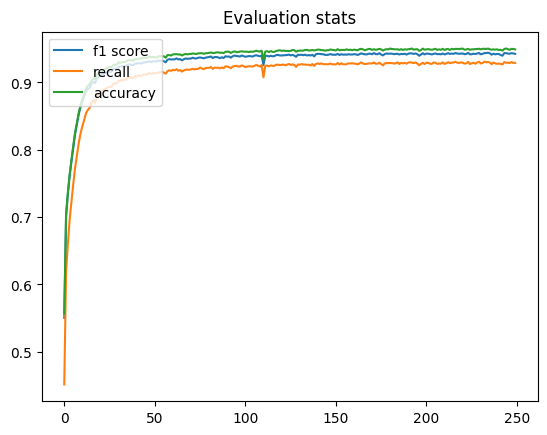

In [39]:
# plot metrics
pyplot.plot(history.history["f1_m"],  label="f1 score")

pyplot.plot(history.history["recall_m"], label="recall")
pyplot.plot(history.history['acc'] , label="accuracy")
pyplot.title('Evaluation stats')
pyplot.legend(loc="upper left")
pyplot.show()

In [40]:
# serialize model to JSON
model_json = m.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [41]:
# load json and create model
from keras.models import model_from_json 

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_val, y_val, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 74.23%
